# Import dataset and relevant libraries

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE


In [2]:
df = pd.read_csv("drinking_water_potability.csv")

In [3]:
df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.68774,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.71654,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.09176,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.58385,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.50849,9.077200,404.041635,563.885482,17.927806,71.976601,4.370562,0


# Data preprocessing

In [ ]:
def process_remove_outliers_quartile(df: pd.DataFrame) -> pd.DataFrame:
    """Remove outliers outside 1.5 IQR"""
    filtered = df.copy()
    for column in df.columns:
        # Computing IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
        filtered = filtered.query(f'(@Q1 - 1.5 * @IQR) <= {column} <= (@Q3 + 1.5 * @IQR) or ({column} != {column})')
    return filtered

# Exploring the dataset

## Looking for missing values and outliers

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
ph                 2785 non-null float64
Hardness           3276 non-null float64
Solids             3276 non-null float64
Chloramines        3276 non-null float64
Sulfate            2495 non-null float64
Conductivity       3276 non-null float64
Organic_carbon     3276 non-null float64
Trihalomethanes    3114 non-null float64
Turbidity          3276 non-null float64
Potability         3276 non-null int64
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [6]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [7]:
df.isnull().sum()/len(df)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

- Pour Thrihalomethanes, moins de 5% des lignes sont manquantes. On pourrait drop ces lignes sans trop impacter notre dataset
- Cependant pour PH et Sulfate il y a beaucoup trop de valeurs manquantes donc il faudra les remplacer. Soit vérifier si cela provient de la valeur d'une autre variable et l'utiliser pour remplacer les valeurs manquantes, soit utiliser la mediane ou la moyenne


In [8]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


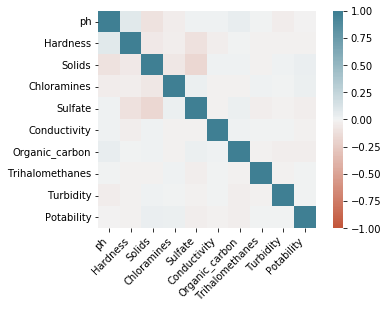

In [9]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
df[df.ph.isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.318980,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
8,NaN,118.988579,14285.583850,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
13,NaN,150.174923,27331.361960,6.838223,299.415781,379.761835,19.370807,76.509996,4.413974,0
20,NaN,227.435048,22305.567410,10.333918,NaN,554.820087,16.331693,45.382815,4.133423,0
22,NaN,215.977859,17107.224230,5.607060,326.943978,436.256194,14.189062,59.855476,5.459251,0
...,...,...,...,...,...,...,...,...,...,...
3224,NaN,198.218700,31081.735260,7.419106,NaN,517.925946,11.711419,85.428785,3.345543,1
3229,NaN,203.204659,10643.186770,6.828936,NaN,384.597711,16.011328,72.911573,3.065910,1
3231,NaN,225.754109,28194.452650,5.892830,366.201583,418.272901,17.306832,103.912548,3.855895,1
3245,NaN,188.536608,24711.414930,7.129520,NaN,555.548534,16.959269,56.038702,4.331691,1


- Regarding the PH as we can see there are no variables really correlated with the PH. We could do either replace the missing values by the mean or median, or we could do something a little bit more meaningful. We have the WHO recommendations regarding the PH of potable water. We could replace the missing values by these recommended values so it could make more sense regarding our use case.

In [11]:
df[df.Sulfate.isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
11,7.974522,218.693300,18767.65668,8.110385,NaN,364.098230,14.525746,76.485911,4.011718,0
14,7.496232,205.344982,28388.00489,5.072558,NaN,444.645352,13.228311,70.300213,4.777382,0
16,7.051786,211.049406,30980.60079,10.094796,NaN,315.141267,20.397022,56.651604,4.268429,0
...,...,...,...,...,...,...,...,...,...,...
3266,8.372910,169.087052,14622.74549,7.547984,NaN,464.525552,11.083027,38.435151,4.906358,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


- Same thing as for the PH. There is no obvious correlated variable in the dataset with the SULFATE. Therefore, we could either replace the values by the mean or median, or we could replace it with recommendations by WHO so it makes more sense with our use case.

- Ultimately we can train our model on a dataset with the values filled with the mean(or median) and another model on a dataset filled with the WHO proposed values  

# PCA

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [28]:
imputer=SimpleImputer(strategy="mean")
X=imputer.fit_transform(X)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [30]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(3276, 9)

In [31]:
pd.DataFrame(pca.components_.T).loc[:4,:5]


,0,1,2,3,4,5
0,-0.315065,-0.552552,-0.085263,-0.006221,-0.196395,-0.081325
1,0.010200,-0.626447,0.369710,-0.204262,-0.042335,0.190357
2,0.669280,0.057273,-0.186564,0.080076,0.198967,0.033211
3,-0.254096,0.321356,0.360302,0.177137,-0.053077,0.721061
4,-0.586623,0.307763,-0.256632,-0.116845,0.058904,-0.265051


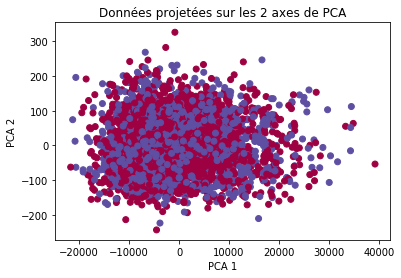

La part de variance expliquée est 1.0


In [37]:
pca = PCA(n_components = 2)
data_2D = pca.fit_transform(X)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(data_2D[:, 0], data_2D[:, 1], c = y, cmap=plt.cm.Spectral)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show();

print("La part de variance expliquée est", round(pca.explained_variance_ratio_.sum(),2))

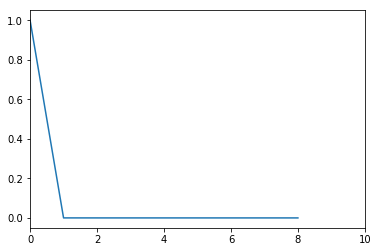

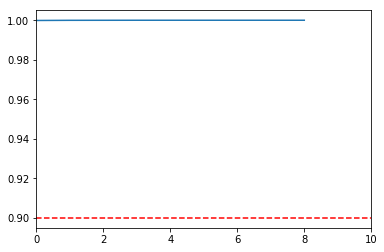

In [40]:
pca = PCA()
pca.fit(X)

plt.figure()
plt.xlim(0,10)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,10)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [44]:
tsne = TSNE(n_components=2, method = 'barnes_hut')
dataTSNE = tsne.fit_transform(X)

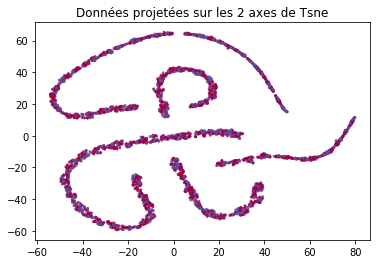

In [46]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataTSNE[:, 0], dataTSNE[:, 1],  c = y, cmap=plt.cm.Spectral, alpha = .7, s = 4)

ax.set_title("Données projetées sur les 2 axes de Tsne")
plt.show();

## Visualisations du jeu de données

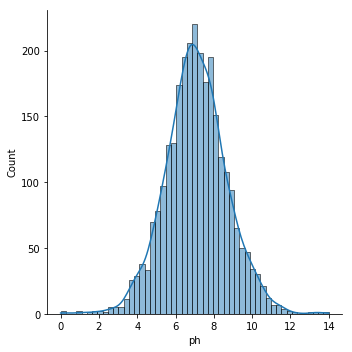

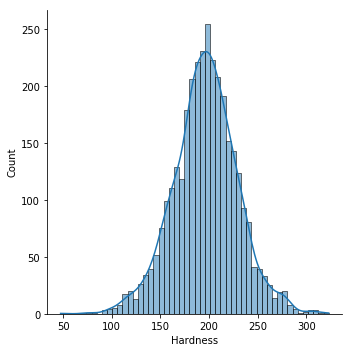

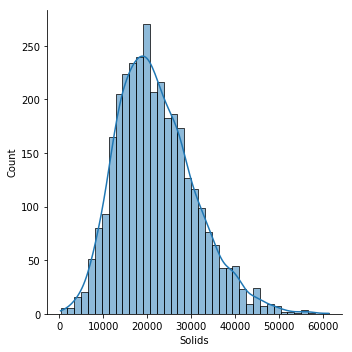

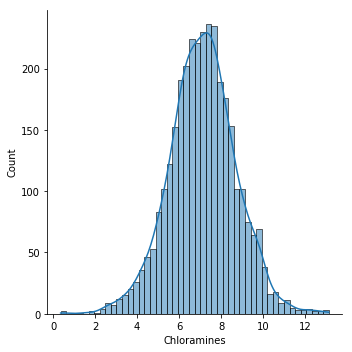

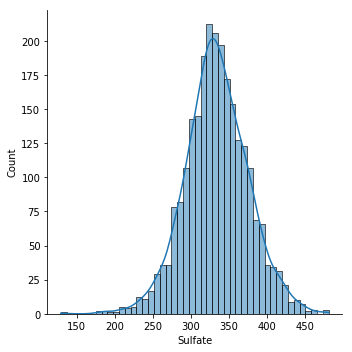

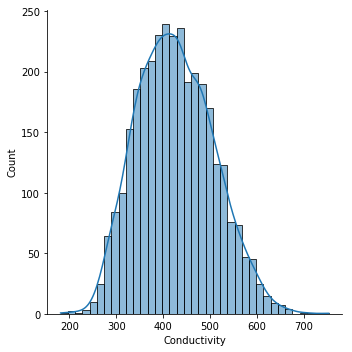

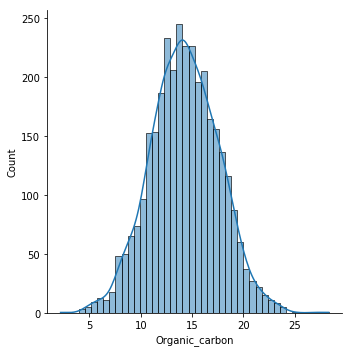

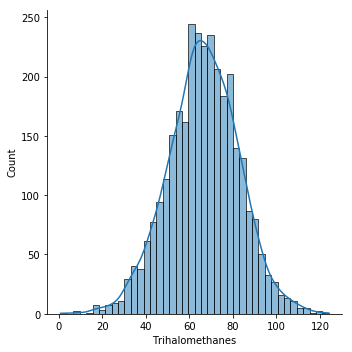

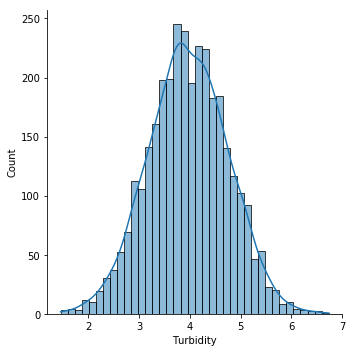

In [14]:
# Analyse de la distribution des variables

for axis in df.columns: 
    if axis != 'Potability':
        sns.displot(df[axis], kde= True)
plt.show()

>- Toutes les variables continues semblent suivre une loi normale, et ne pas comporter de valeurs aberrantes. Elles semblent cependant présenter une faible corrélation avec la cible. 


In [15]:
# Valeurs aberrrantes ? yessir

In [16]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Preprocessing 

## Entraînement du modèle 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
full_pipeline = Pipeline([
    ('missing', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler()),
    ('classifier',RandomForestClassifier())
])

In [19]:
full_pipeline.fit(X_train, y_train)
# Test the linear regressor on the test data.
predictions = full_pipeline.predict(X_test)
accuracy=accuracy_score(y_test,predictions)
print(accuracy)

0.6951219512195121


In [ ]:
##Definition de la fonction pour drop les data points qui s'écartent de 1.5*IQR sur chaque feature
def remove_outliers_IQR(df):
    for feature in df.columns:
        Q25,Q75=percentile(df[feature],25),percentile(df[feature],25)
        cutoff=(Q25-Q75)*1.75
        lower, upper = q25 - cutoff, q75 + cutoff
        df = df[(df[feature] >= lower) & (df[feature] <= upper)]

